In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import math
import scipy
import scipy.stats
from PendulumProblem import *
#multivariate_normal

In [50]:
class MDP:
    def __init__(self):
        #test with different hyper parameter
        pi = math.pi
        self.dt = 0.1
        self.n_1 = 80
        self.max_theta = math.pi
        self.v_max = 10
        self.u_max = 10
        self.n_2 = 20
        self.n_u = 50
        self.a = 1
        self.b = 0.1
        self.sigma = np.eye(2)*1
        self.k = 1
        self.r = 0.01
        self.gamma = 0.3
        X1 = np.linspace(-self.max_theta, self.max_theta, self.n_1)
        X2 = np.linspace(-self.v_max, self.v_max, self.n_2)
        self.X1_matrix, self.X2_matrix = np.meshgrid(X1, X2)
        self.U = np.linspace(-self.u_max, self.u_max, self.n_u)[:, None]
        # if we want to find a state(i,j) which means i index in x1 and j index in x2, the index in flat is i+n_1*j
        self.flat_x = [i for i in zip(self.X1_matrix.flat, self.X2_matrix.flat)]
        self.number_states = len(self.flat_x)
        self.number_U = self.U.shape[0]
        x1_list = np.copy(self.X1_matrix)
        x2_list = np.copy(self.X2_matrix)
        self.cov = self.sigma.dot(self.sigma.T) * self.dt
        self.transition_matrix = np.zeros((self.number_states, self.number_states, self.number_U))
        self.l_matrix = np.zeros((self.number_states, self.number_U))
        
        f1 = x2_list
        f2 = self.a * np.sin(x1_list) - self.b * x2_list
        for i in range(self.number_U):
            u = self.U[i,0]
            self.l_matrix[:, i] = (1. - np.exp(self.k * (np.cos(np.array(self.flat_x)[:,0])-1)) + 0.5*self.r*u**2.) * self.dt
            #only f2 is effected by u
            f2u = f2+u
            x1_next = x1_list + f1 * self.dt
            #modify for exceed 2pi
            x1_next = (x1_next + pi) % (2 * pi) - pi
            x2_next = x2_list + f2u * self.dt
            
            x2_next[x2_next < -self.v_max] = -self.v_max
            x2_next[x2_next > self.v_max] = self.v_max
            x_next = [x for x in zip(x1_next.flat, x2_next.flat)]
            for j, x in enumerate(x_next):
                #compute the Gaussian probability
                Gaussian_p = scipy.stats.multivariate_normal.pdf(self.flat_x, mean=x, cov=self.cov)        
                #normalize
                self.transition_matrix[j, :, i] = Gaussian_p/Gaussian_p.sum()
        self.V = np.zeros((self.number_states, 1))
        self.policy = None
        self.discount = 0.9
        self.track_V = []

    def Solve_Bellman_Equation(self,V):
        Q = np.zeros((self.number_states, self.number_U))
        for i in range(self.number_U):
            
            Q[:,i] = self.l_matrix[:,i].squeeze() + (self.discount * (self.transition_matrix[:,:,i]).dot(V)).squeeze()
        policy = Q.argmin(axis=1)
        value = Q.min(axis=1)[:, None]
        return policy, value
        
    def VI(self):
        #self._clean()
        count = 0
        while True:
            count += 1
            cur_V= self.V.copy()
            self.track_V.append(self.V)
            self.policy, self.V = self.Solve_Bellman_Equation(cur_V)
            difference = abs(self.V - cur_V)
            #print(difference)
            if np.max(difference)< 0.01:
                print("VI convegre")
                break
        print ("number of value iteration", count)
        
    def PI(self):
        count = 0
        value_idx = np.arange(self.number_states)
        self.policy = np.random.choice(self.number_U, self.number_states)
        
        while True:
            count += 1
            cur_V= self.V.copy()
            self.track_V.append(self.V)
            linear_l = self.l_matrix[value_idx,self.policy][:, None] #1 * 10000s

            cur_policy_transition_matrix = np.zeros((self.number_states, self.number_states))
            for i in range(self.number_states):
                cur_policy_transition_matrix[i, :] = self.transition_matrix[i, :,self.policy[i]]
            I = np.eye(self.number_states)
            reverse = (np.linalg.inv(I - self.discount * cur_policy_transition_matrix)).dot(linear_l)
            self.policy, self.V = self.Solve_Bellman_Equation(reverse)
            difference = abs(self.V - cur_V)
            if np.max(difference) < 0.001:
                print("PI converge")
                break
        print ("number of Policy Iteration: ", count)
        
    def search_method(self,initial_state,method="PI"):
        if(method=="PI"):
            self.PI()
            print("finish PI")
        else:
            self.VI()
            print("finish VI")
        optimal_policy = self.policy.reshape(self.n_2, self.n_1)
        state = initial_state
        state_list = []
        #interpolation
        interpolation = scipy.interpolate.interp2d(np.arange(self.n_1), np.arange(self.n_2), optimal_policy, kind='linear')
        print("begin to generate policy")
        for i in range(1000):
            state_list.append(state)
            id1 = (state[0] + self.max_theta) / (2. * self.max_theta/(self.n_1 - 1))
            id2 = (state[1] + self.v_max) / (2. * self.v_max/(self.n_2 - 1))
            #from interpolation to choose the policy
            choose_policy = interpolation(id1, id2) 
            u = -self.u_max + choose_policy * (2. * self.u_max/ (self.number_U - 1))
            d_omega = np.random.multivariate_normal(np.array([0, 0]), 0.1*np.eye(2), 1)[0]
            f_xu = np.array([state[1], self.a * np.sin(state[0]) - self.b * np.cos(state[1]) + u])
            state = state + self.dt * f_xu + (self.sigma.dot(d_omega)).flatten()
            #check the value of state is valid or not, if not , modify it
            state[0] = (state[0] + math.pi) % (2 * math.pi) - math.pi
            state[1] = min(max(state[1], -self.v_max),self.v_max)
        print("finish genaration")
        return np.array(state_list)

In [51]:
sol = MDP()

In [52]:
policy = sol.search_method(np.array([math.pi, 0]),"PI")

PI converge
number of Policy Iteration:  6
finish PI
begin to generate policy
finish genaration


Traceback (most recent call last):
  File "C:\Users\yidi6\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 215, in process
    func(*args, **kwargs)
  File "C:\Users\yidi6\Anaconda3\lib\site-packages\matplotlib\animation.py", line 1478, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


<IPython.core.display.Javascript object>


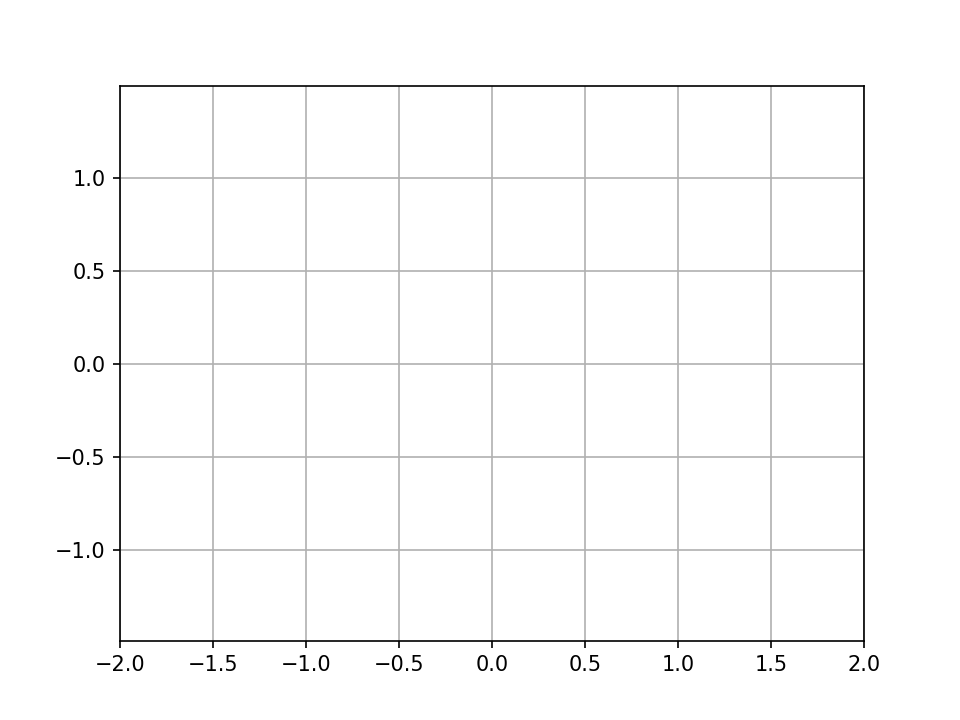

In [53]:
%matplotlib notebook
animation = EnvAnimate()

<IPython.core.display.Javascript object>


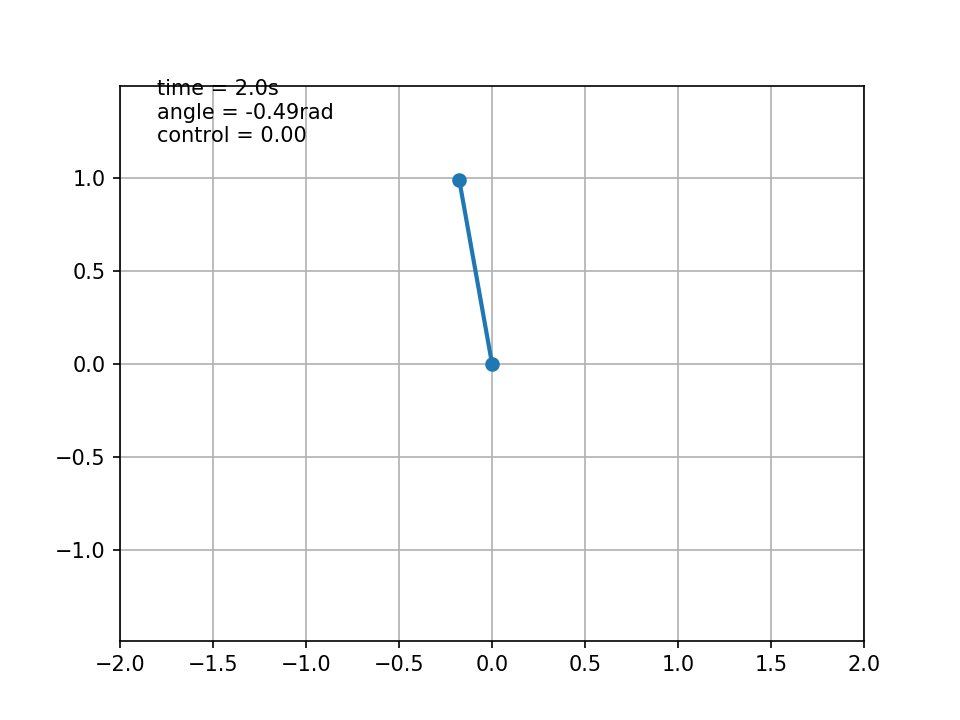

Starting Animation



In [55]:
animation.new_data(policy[:,0])
animation.start()

<IPython.core.display.Javascript object>


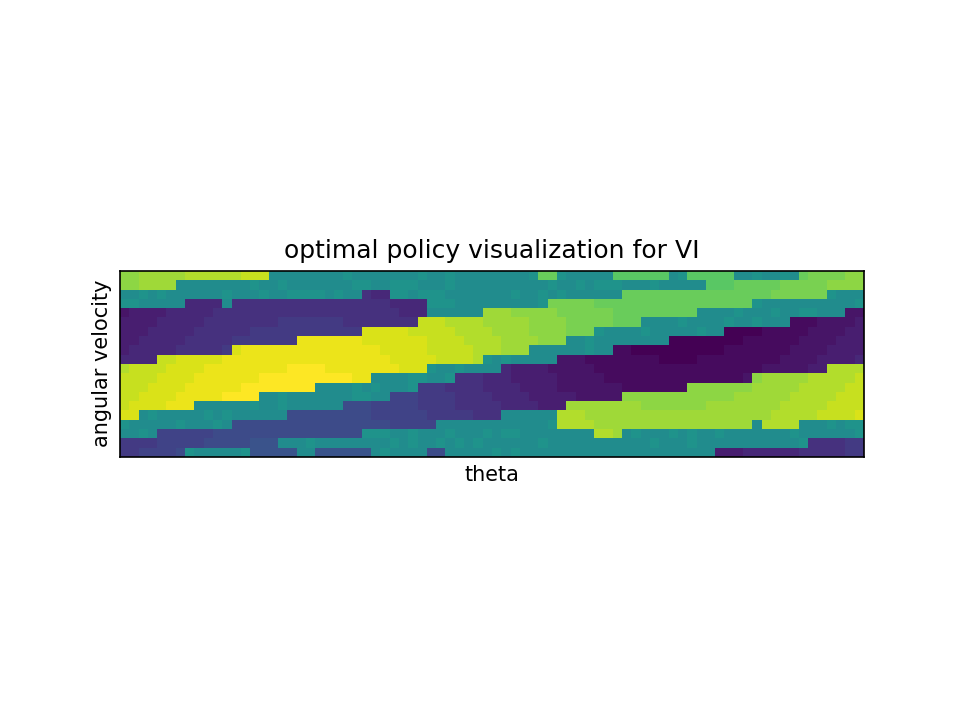

In [40]:
plt.figure()
my_x_ticks = np.arange(-math.pi, math.pi, 60)
my_y_ticks = np.arange(-30, 30, 60)
plt.xticks(my_x_ticks)
plt.yticks(my_y_ticks)
plt.imshow(sol.policy.reshape(sol.n_2, sol.n_1))
plt.title('optimal policy visualization for VI')
plt.xlabel('theta')
plt.ylabel('angular velocity')
plt.savefig("optimal policy visualization for VI")

In [41]:
sol.policy.reshape(sol.n_2, sol.n_1).shape

(20, 80)

In [42]:
sol.V.reshape(sol.n_2, sol.n_1)

array([[0.40211304, 0.39684438, 0.39314646, ..., 0.41515651, 0.40835728,
        0.40211304],
       [0.33369178, 0.34086403, 0.3484309 , ..., 0.32480609, 0.32840739,
        0.33369178],
       [0.33315242, 0.3407157 , 0.34916369, ..., 0.32143815, 0.32669037,
        0.33315242],
       ...,
       [0.33315242, 0.32669037, 0.32143815, ..., 0.34916369, 0.3407157 ,
        0.33315242],
       [0.33369178, 0.32840739, 0.32480609, ..., 0.3484309 , 0.34086403,
        0.33369178],
       [0.40211304, 0.40835728, 0.41515651, ..., 0.39314646, 0.39684438,
        0.40211304]])

In [43]:
a = np.array(sol.track_V).reshape(-1,1600)

In [44]:
a.shape

(9, 1600)

[0.         0.61048748 0.46322216 0.39267621 0.38437963 0.38198747
 0.38040117 0.38040117 0.38040117]


<IPython.core.display.Javascript object>


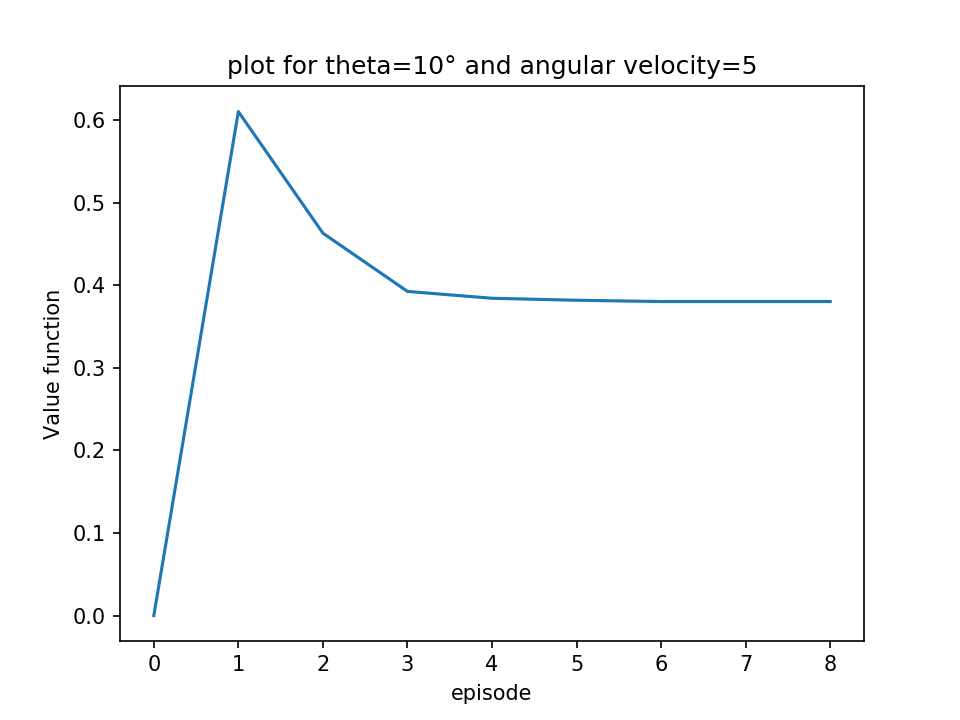

In [45]:
# for state(theta = 10° and angular velocity =5) 
state = [math.pi/18,5]
id1 = round((state[0] + sol.max_theta) / (2. * sol.max_theta/(sol.n_1 - 1)))
id2 = round((state[1] + sol.v_max) / (2. * sol.v_max/(sol.n_2 - 1)))
print(a[:,id1+sol.n_1*id2])
plt.figure()
plt.plot(a[:,id1+sol.n_1*id2])
plt.xlabel("episode")
plt.ylabel("Value function")
plt.title("plot for theta=10° and angular velocity=5")
#plt.xticks(np.linspace(0, 7000, 8))
plt.savefig("plot for theta=10° and angular velocity=5")
plt.show()

In [46]:
a[:,id1+sol.n_1*id2]

array([0.        , 0.61048748, 0.46322216, 0.39267621, 0.38437963,
       0.38198747, 0.38040117, 0.38040117, 0.38040117])

[0.         0.57582179 0.40927381 0.36061445 0.32878362 0.28225033
 0.28223513 0.28223513 0.28223513]


<IPython.core.display.Javascript object>


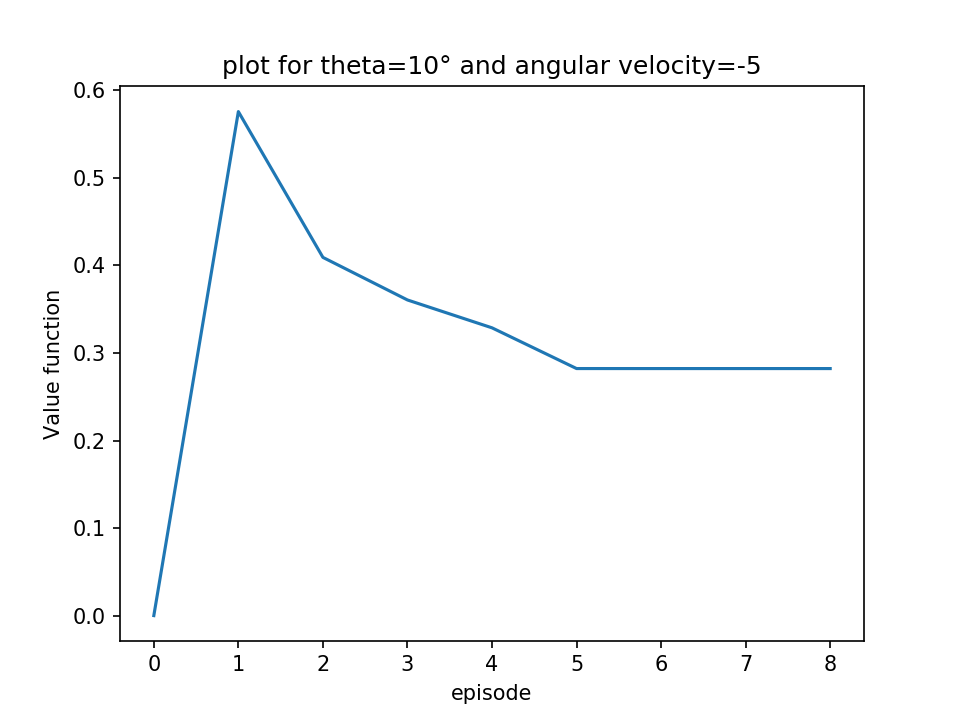

In [47]:
# for state(theta = 10° and angular velocity =-5) 
state = [math.pi/18,-5]
id1 = round((state[0] + sol.max_theta) / (2. * sol.max_theta/(sol.n_1 - 1)))
id2 = round((state[1] + sol.v_max) / (2. * sol.v_max/(sol.n_2 - 1)))
print(a[:,id1+sol.n_1*id2])
plt.figure()
plt.plot(a[:,id1+sol.n_1*id2])
plt.xlabel("episode")
plt.ylabel("Value function")
plt.title("plot for theta=10° and angular velocity=-5")
#plt.xticks(np.linspace(0, 7000, 8))
plt.savefig("plot for theta=10° and angular velocity=-5")
plt.show()

[0.         0.27008349 0.13665986 0.0740941  0.05250682 0.05206371
 0.05202335 0.05202335 0.05202335]


<IPython.core.display.Javascript object>


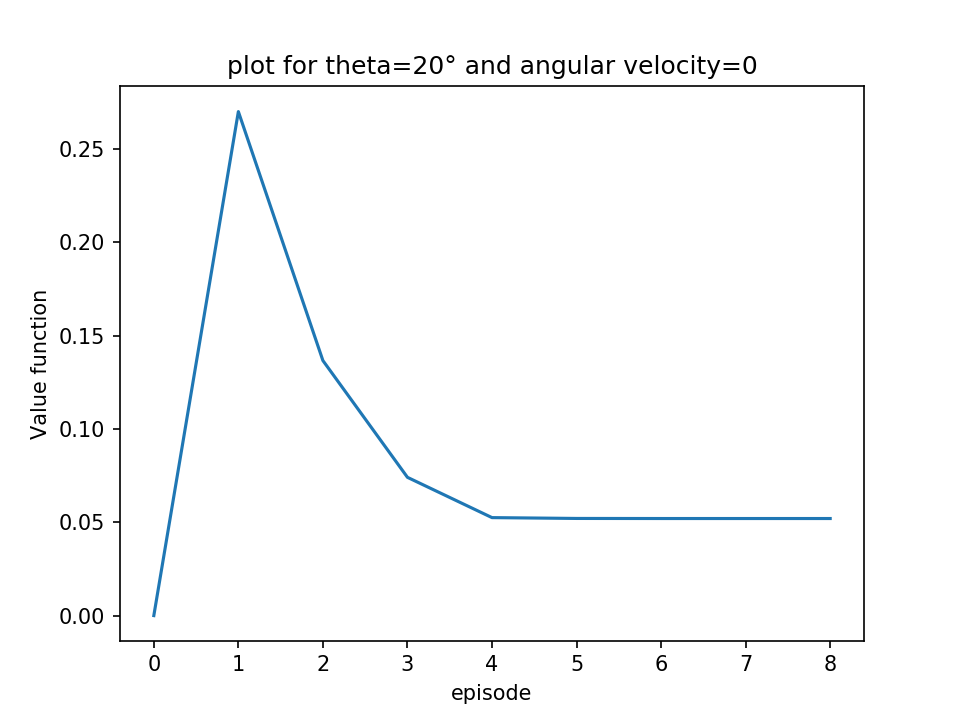

In [48]:
# for state(theta = 20° and angular velocity =0) 
state = [math.pi/9,0]
id1 = round((state[0] + sol.max_theta) / (2. * sol.max_theta/(sol.n_1 - 1)))
id2 = round((state[1] + sol.v_max) / (2. * sol.v_max/(sol.n_2 - 1)))
print(a[:,id1+sol.n_1*id2])
plt.figure()
plt.plot(a[:,id1+sol.n_1*id2])
plt.xlabel("episode")
plt.ylabel("Value function")
plt.title("plot for theta=20° and angular velocity=0")
#plt.xticks(np.linspace(0, 7000, 8))
plt.savefig("plot for theta=20° and angular velocity=0")
plt.show()

[0.         0.57264566 0.42102804 0.36624351 0.28601795 0.28262296
 0.28223513 0.28223513 0.28223513]


<IPython.core.display.Javascript object>


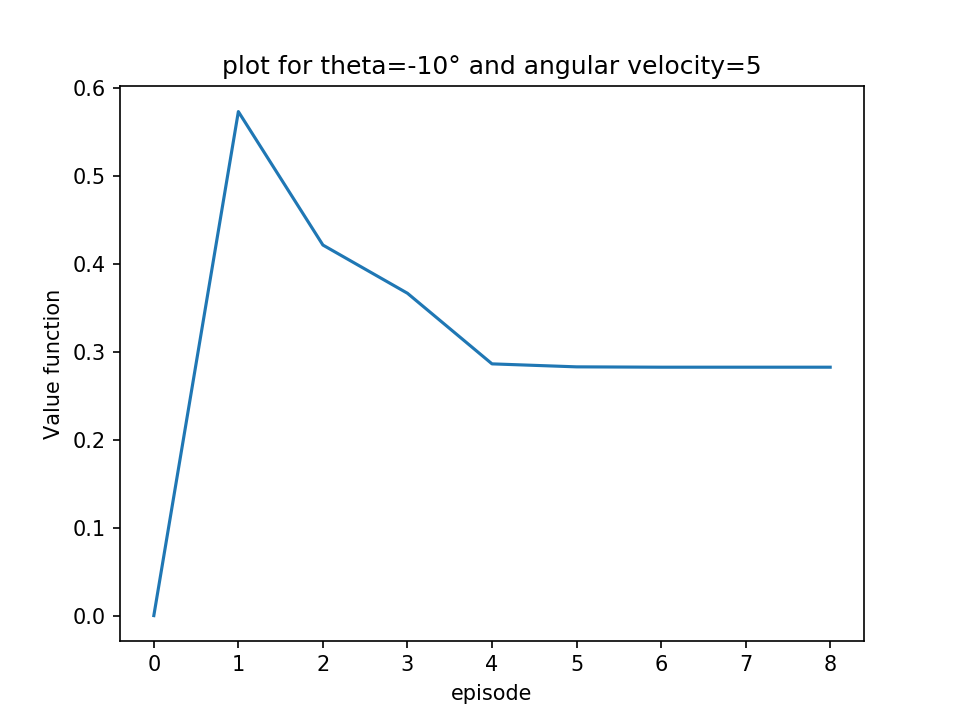

In [49]:
# for state(theta = -10° and angular velocity =5) 
state = [-math.pi/18,5]
id1 = round((state[0] + sol.max_theta) / (2. * sol.max_theta/(sol.n_1 - 1)))
id2 = round((state[1] + sol.v_max) / (2. * sol.v_max/(sol.n_2 - 1)))
print(a[:,id1+sol.n_1*id2])
plt.figure()
plt.plot(a[:,id1+sol.n_1*id2])
plt.xlabel("episode")
plt.ylabel("Value function")
plt.title("plot for theta=-10° and angular velocity=5")
#plt.xticks(np.linspace(0, 7000, 8))
plt.savefig("plot for theta=-10° and angular velocity=5")
plt.show()